In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
from typing import List

In [2]:
from torch.utils.data import Dataset, DataLoader
DATA_FOLDER = 'mask_output/images'


# Data loading + splits (train/val/test)

In [3]:
import re
from pathlib import Path
from collections import defaultdict, Counter
from typing import Tuple, Optional, Sequence
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Subset, WeightedRandomSampler
import math


In [4]:
def label_from_filename(path: str) -> str:
    name = Path(path).name
    LABEL_RE = re.compile(r"_annot\d+_(?P<label>.+?)_image\.(png|jpg|jpeg)$", flags=re.IGNORECASE)

    match = LABEL_RE.search(name)
    if not match:
        raise ValueError(f"Cannot parse label from filename: {name}")
    label = match.group("label").strip()
    # Some files have trailing underscores (e.g. 'Ignore_' / 'Region_'); normalize.
    label = label.strip("_")
    return label

def list_image_files(data_folder: str, exts: Sequence[str] = (".png", ".jpg", ".jpeg")) -> list[Path]:
    root = Path(data_folder)
    if not root.exists():
        raise FileNotFoundError(f"DATA_FOLDER not found: {root.resolve()}")
    files = []
    for ext in exts:
        files.extend(root.rglob(f"*{ext}"))
        files.extend(root.rglob(f"*{ext.upper()}"))
    files = sorted({p for p in files if p.is_file()})
    if not files:
        raise FileNotFoundError(f"No images found under: {root.resolve()}")
    return files

def square_crop_boxes(
    w: int,
    h: int,
    ratio_tol: float = 0.05,
) -> list[tuple[int, int, int, int]]:

    if w <= 0 or h <= 0:
        return []

    sq = min(w, h)
    long_side = max(w, h)
    ratio = long_side / sq

    # Nombre de carrés possibles
    n = int(math.floor(ratio))

    if n <= 0:
        return []

    # Cas quasi-entier 
    if abs(ratio - round(ratio)) <= ratio_tol:
        n = int(round(ratio))
        offsets = [i * sq for i in range(n)]
    else:
        # Cas non entier
        if n == 1:
            offsets = [0]
        else:
            offsets = [
                round(i * (long_side - sq) / (n - 1))
                for i in range(n)
            ]

    boxes = []
    if w >= h:
        for x in offsets:
            boxes.append((x, 0, x + sq, sq))
    else:
        for y in offsets:
            boxes.append((0, y, sq, y + sq))

    return boxes



class FilenameLabelImageDataset(Dataset):
    def __init__(
        self,
        data_folder: str,
        transform: Optional[object] = None,
        exclude_classes: Optional[set[str]] = None,
    ):
        self.data_folder = data_folder
        self.transform = transform
        exclude_classes = exclude_classes or set()
        self.exclude_classes = exclude_classes
        exclude_lc = {c.lower() for c in exclude_classes}

        files = list_image_files(data_folder)
        labels = [label_from_filename(p.name) for p in files]
        keep = [i for i, lab in enumerate(labels) if lab.lower() not in exclude_lc]
        self.files = [files[i] for i in keep]
        self.labels_str_files = [labels[i] for i in keep]

        classes = sorted(set(self.labels_str_files))
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}

        # Expand each image into 1 or 3 square crops depending on aspect ratio.
        samples: list[tuple[Path, tuple[int, int, int, int]]] = []
        labels_str: list[str] = []
        for path, lab in zip(self.files, self.labels_str_files):
            with Image.open(path) as im:
                w, h = im.size
            for box in square_crop_boxes(w, h):
                samples.append((path, box))
                labels_str.append(lab)

        self.samples = samples
        self.labels_str = labels_str
        self.targets = [self.class_to_idx[c] for c in self.labels_str]

    def with_transform(self, transform: Optional[object]):
        ds = object.__new__(FilenameLabelImageDataset)
        ds.data_folder = self.data_folder
        ds.transform = transform
        ds.exclude_classes = self.exclude_classes
        ds.files = self.files
        ds.labels_str_files = self.labels_str_files
        ds.class_to_idx = self.class_to_idx
        ds.idx_to_class = self.idx_to_class
        ds.samples = self.samples
        ds.labels_str = self.labels_str
        ds.targets = self.targets
        return ds

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        path, box = self.samples[idx]
        image = Image.open(path).convert("RGB")
        image = image.crop(box)
        if self.transform is not None:
            image = self.transform(image)
        y = self.targets[idx]
        return image, y

    def class_counts(self) -> Counter:
        return Counter(self.labels_str)


In [5]:
def make_transforms(image_size: int = 224, train: bool = True):
    # Minimal baseline; swap/extend for augmentation later.
    ops = [
        T.Resize((image_size, image_size)),
    ]
    if train:
        # Example augmentation hook (keep minimal):
        ops.append(T.RandomHorizontalFlip(p=0.5))
        ops.append(T.RandomVerticalFlip(p=0.5))
        ops.append(T.RandomRotation(degrees=90))

    ops += [
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return T.Compose(ops)

def stratified_split_indices(labels: Sequence[int], val_frac: float = 0.15, test_frac: float = 0.15) -> Tuple[list[int], list[int], list[int]]:
    by_class = defaultdict(list)
    for i, y in enumerate(labels):
        by_class[int(y)].append(i)

    train_idx  = []
    val_idx = []
    test_idx = []

    for y, idxs in by_class.items():
        idxs = idxs.copy()
        perm = torch.randperm(len(idxs)).tolist()
        idxs = [idxs[i] for i in perm]
        n = len(idxs)
        n_test = int(round(test_frac * n))
        n_val = int(round(val_frac * n))
        if n >= 3:
            n_test = max(1, n_test)
            n_val = max(1, n_val)
        if n_test + n_val >= n:
            n_test = min(n_test, max(0, n - 1))
            n_val = min(n_val, max(0, n - 1 - n_test))
        n_train = n - n_val - n_test
        if n_train <= 0 and n > 0:
            n_train = 1
            if n_val > 0:
                n_val -= 1
            elif n_test > 0:
                n_test -= 1
        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])

    def _shuffle(xs: list[int]) -> list[int]:
        if not xs:
            return xs
        perm = torch.randperm(len(xs)).tolist()
        return [xs[i] for i in perm]

    return _shuffle(train_idx), _shuffle(val_idx), _shuffle(test_idx)

def make_class_weights(targets: Sequence[int], num_classes: int) -> torch.Tensor:
    counts = torch.bincount(torch.as_tensor(list(targets), dtype=torch.long), minlength=num_classes).clamp_min(1)
    total = counts.sum().float()
    weights = total / (num_classes * counts.float())
    return weights

def make_dataloaders(
    data_folder: str,
    batch_size: int = 32,
    image_size: int = 224,
    val_frac: float = 0.15,
    test_frac: float = 0.15,
    seed: int = 42,
    num_workers: int = 0,
    exclude_classes: Optional[set[str]] = None,
    balance_train: bool = True,
 ):
    train_tf = make_transforms(image_size=image_size, train=True)
    eval_tf = make_transforms(image_size=image_size, train=False)

    base_ds = FilenameLabelImageDataset(data_folder, transform=None, exclude_classes=exclude_classes)
    train_idx, val_idx, test_idx = stratified_split_indices(base_ds.targets, val_frac, test_frac)

    train_ds = base_ds.with_transform(train_tf)
    val_ds = base_ds.with_transform(eval_tf)
    test_ds = base_ds.with_transform(eval_tf)

    train_subset = Subset(train_ds, train_idx)
    val_subset = Subset(val_ds, val_idx)
    test_subset = Subset(test_ds, test_idx)

    num_classes = len(base_ds.class_to_idx)
    train_targets = [base_ds.targets[i] for i in train_idx]
    class_weights = make_class_weights(train_targets, num_classes=num_classes)

    sampler = None
    if balance_train:
        sample_weights = class_weights[torch.as_tensor(train_targets, dtype=torch.long)]
        rng = torch.Generator().manual_seed(seed)
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_targets), replacement=True, generator=rng)

    pin_memory = torch.cuda.is_available()
    loaders = {
        "train": DataLoader(train_subset, batch_size=batch_size, shuffle=(sampler is None), sampler=sampler, num_workers=num_workers, pin_memory=pin_memory),
        "val": DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory),
        "test": DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory),
    }
    meta = {
        "class_to_idx": base_ds.class_to_idx,
        "idx_to_class": base_ds.idx_to_class,
        "counts": base_ds.class_counts(),
        "sizes": {"train": len(train_subset), "val": len(val_subset), "test": len(test_subset)},
        "class_weights": class_weights,
    }
    return loaders, meta


In [6]:
CFG = {
    "data_folder": DATA_FOLDER,
    "batch_size": 32,
    "image_size": 224,
    "splits": {"val": 0.15, "test": 0.15},
    "num_workers": 0,
    "exclude_classes": {"Region"},
    # Handle class imbalance
    "balance_train": True,   
    "weighted_loss": True, 
}

dataloaders, data_meta = make_dataloaders(
    data_folder=CFG["data_folder"],
    batch_size=CFG["batch_size"],
    image_size=CFG["image_size"],
    val_frac=CFG["splits"]["val"],
    test_frac=CFG["splits"]["test"],
    num_workers=CFG["num_workers"],
    exclude_classes=CFG["exclude_classes"],
    balance_train=CFG["balance_train"],
 )

print("Classes:", data_meta["class_to_idx"])
print("Counts:", data_meta["counts"])
print("Split sizes:", data_meta["sizes"])
print("Class weights:", data_meta["class_weights"].tolist())

xb, yb = next(iter(dataloaders["train"]))
print("Batch x:", tuple(xb.shape), "Batch y:", tuple(yb.shape), "y sample:", yb[:8].tolist())


Classes: {'Ignore': 0, 'Necrosis': 1, 'Stroma': 2, 'Tumor': 3}
Counts: Counter({'Stroma': 607, 'Ignore': 524, 'Necrosis': 284, 'Tumor': 228})
Split sizes: {'train': 1149, 'val': 247, 'test': 247}
Class weights: [0.7848360538482666, 1.450757622718811, 0.6758823394775391, 1.795312523841858]
Batch x: (32, 3, 224, 224) Batch y: (32,) y sample: [1, 3, 3, 3, 0, 0, 0, 1]


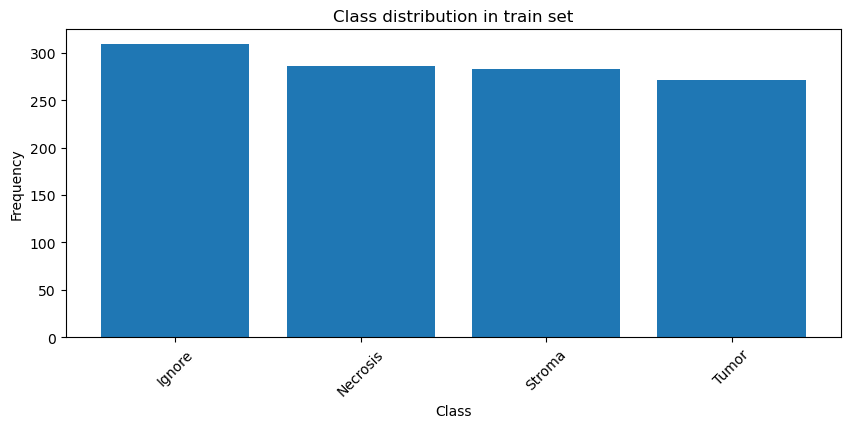

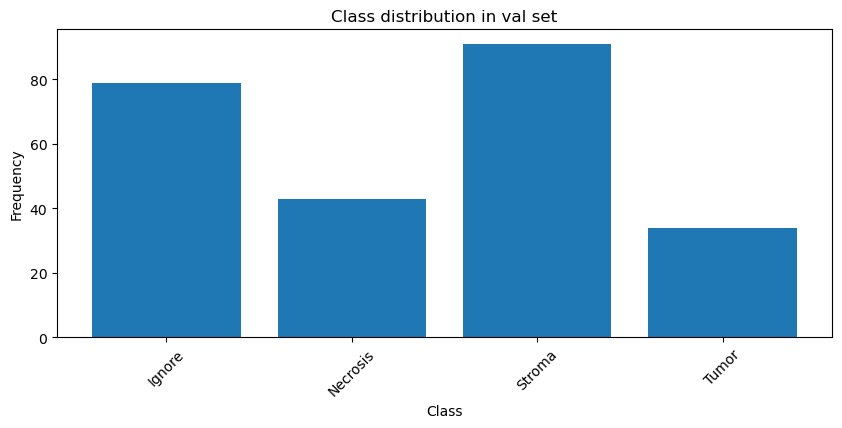

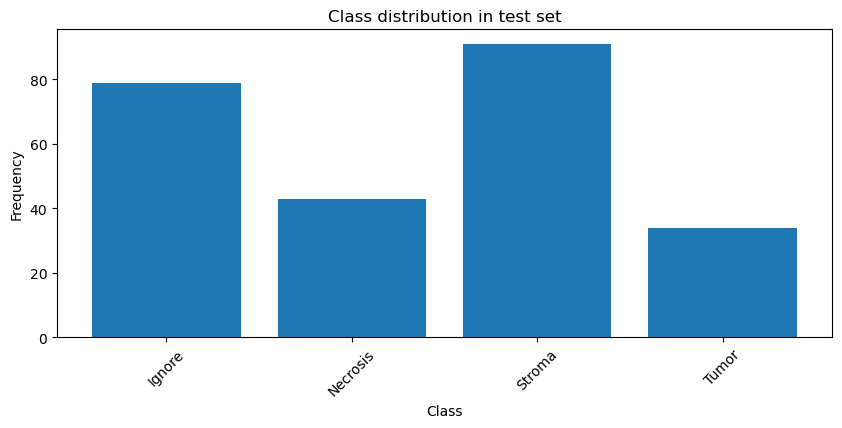

In [7]:
import matplotlib.pyplot as plt
# Check balance of classes in splits
for split in ["train", "val", "test"]:
    loader = dataloaders[split]
    all_labels: List[int] = []
    for _, y in loader:
        all_labels.extend(y.tolist())
    counts = Counter(all_labels)
    labels = list(data_meta["idx_to_class"].values())
    freqs = [counts.get(i, 0) for i in range(len(labels))]
    plt.figure(figsize=(10, 4))
    plt.bar(labels, freqs)
    plt.title(f"Class distribution in {split} set")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

In [8]:
import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

class CNN(nn.Module): 
    def __init__(self, num_classes: int):
        super(CNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = F.softmax(logits, dim=1)
        return probs
    
    def evaluate(self, dataloader: DataLoader, device: torch.device):
        self.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                logits = self.forward(x)
                _, predicted = torch.max(logits, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        accuracy = correct / total if total > 0 else 0.0
        return accuracy
    
model = CNN(num_classes=len(data_meta["class_to_idx"]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_weight = None
if CFG.get("weighted_loss", False):
    loss_weight = data_meta["class_weights"].to(device)
criterion = nn.CrossEntropyLoss(weight=loss_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Metrics
history = [] 
epoch_train_loss = []
epoch_train_acc = []
epoch_val_loss = []
history_val = []
best_val_acc = 0.0
for epoch in range(20):
    model.train()
    running_loss = 0.0
    running_samples = 0
    running_correct = 0
    for x, y in tqdm.tqdm(dataloaders["train"]):
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        history.append(loss.item())
        running_loss += loss.item() * y.size(0)
        running_samples += y.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == y).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # epoch stats on training set
    train_loss_epoch = running_loss / running_samples if running_samples > 0 else 0.0
    train_acc_epoch = running_correct / running_samples if running_samples > 0 else 0.0
    epoch_train_loss.append(train_loss_epoch)
    epoch_train_acc.append(train_acc_epoch)

    # Validation: compute loss and accuracy
    model.eval()
    val_loss_accum = 0.0
    val_samples = 0
    val_correct = 0
    with torch.no_grad():
        for x, y in dataloaders['val']:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss_accum += loss.item() * y.size(0)
            val_samples += y.size(0)
            _, preds = torch.max(logits, 1)
            val_correct += (preds == y).sum().item()
        
    val_loss_epoch = val_loss_accum / val_samples if val_samples > 0 else 0.0
    val_acc_epoch = val_correct / val_samples if val_samples > 0 else 0.0
    if val_acc_epoch > best_val_acc:
        best_val_acc = val_acc_epoch
        torch.save(model.state_dict(), "best_model.pth")
    epoch_val_loss.append(val_loss_epoch)
    history_val.append(val_acc_epoch)

    print(f"Epoch {epoch+1}: train_loss={train_loss_epoch:.4f}, train_acc={train_acc_epoch:.4f}, val_loss={val_loss_epoch:.4f}, val_acc={val_acc_epoch:.4f}")

# After training: compute test metrics and confusion matrix
model.eval()
y_true = []
y_pred = []
y_prob = []
with torch.no_grad():
    for x, y in dataloaders['test']:
        x = x.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.numpy().tolist())
        y_prob.extend(probs.cpu().numpy().tolist())

labels = [data_meta['idx_to_class'][i] for i in range(len(data_meta['idx_to_class']))]
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=list(range(len(labels))), zero_division=0)

print('\nClassification report:')
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))


/Users/dimitri/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dimitri/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 36/36 [01:37<00:00,  2.71s/it]


Epoch 1: train_loss=0.9866, train_acc=0.6023, val_loss=0.9495, val_acc=0.6842


100%|██████████| 36/36 [01:33<00:00,  2.60s/it]


Epoch 2: train_loss=0.5230, train_acc=0.8294, val_loss=0.7064, val_acc=0.7652


100%|██████████| 36/36 [01:34<00:00,  2.62s/it]


Epoch 3: train_loss=0.3720, train_acc=0.8625, val_loss=0.5389, val_acc=0.7976


100%|██████████| 36/36 [01:43<00:00,  2.88s/it]


Epoch 4: train_loss=0.2885, train_acc=0.8773, val_loss=0.4383, val_acc=0.8219


100%|██████████| 36/36 [01:34<00:00,  2.63s/it]


Epoch 5: train_loss=0.2411, train_acc=0.9173, val_loss=0.3866, val_acc=0.8219


100%|██████████| 36/36 [01:35<00:00,  2.65s/it]


Epoch 6: train_loss=0.2299, train_acc=0.9164, val_loss=0.3711, val_acc=0.8300


100%|██████████| 36/36 [01:33<00:00,  2.61s/it]


Epoch 7: train_loss=0.2126, train_acc=0.9147, val_loss=0.3300, val_acc=0.8340


100%|██████████| 36/36 [01:33<00:00,  2.59s/it]


Epoch 8: train_loss=0.1744, train_acc=0.9347, val_loss=0.3163, val_acc=0.8462


100%|██████████| 36/36 [01:34<00:00,  2.63s/it]


Epoch 9: train_loss=0.1814, train_acc=0.9269, val_loss=0.3328, val_acc=0.8502


100%|██████████| 36/36 [01:35<00:00,  2.64s/it]


Epoch 10: train_loss=0.1574, train_acc=0.9399, val_loss=0.2603, val_acc=0.8745


100%|██████████| 36/36 [01:33<00:00,  2.59s/it]


Epoch 11: train_loss=0.1380, train_acc=0.9469, val_loss=0.2621, val_acc=0.8623


100%|██████████| 36/36 [01:34<00:00,  2.62s/it]


Epoch 12: train_loss=0.1408, train_acc=0.9417, val_loss=0.2244, val_acc=0.9028


100%|██████████| 36/36 [01:41<00:00,  2.83s/it]


Epoch 13: train_loss=0.1356, train_acc=0.9478, val_loss=0.2468, val_acc=0.8907


100%|██████████| 36/36 [01:44<00:00,  2.89s/it]


Epoch 14: train_loss=0.1212, train_acc=0.9574, val_loss=0.2389, val_acc=0.8988


100%|██████████| 36/36 [01:46<00:00,  2.96s/it]


Epoch 15: train_loss=0.1186, train_acc=0.9565, val_loss=0.2185, val_acc=0.8907


100%|██████████| 36/36 [01:42<00:00,  2.84s/it]


Epoch 16: train_loss=0.1229, train_acc=0.9487, val_loss=0.2231, val_acc=0.8947


100%|██████████| 36/36 [01:42<00:00,  2.85s/it]


Epoch 17: train_loss=0.1237, train_acc=0.9469, val_loss=0.2343, val_acc=0.8947


100%|██████████| 36/36 [01:38<00:00,  2.72s/it]


Epoch 18: train_loss=0.0953, train_acc=0.9661, val_loss=0.2258, val_acc=0.9028


100%|██████████| 36/36 [01:37<00:00,  2.70s/it]


Epoch 19: train_loss=0.1091, train_acc=0.9539, val_loss=0.2307, val_acc=0.8866


100%|██████████| 36/36 [01:36<00:00,  2.68s/it]


Epoch 20: train_loss=0.0974, train_acc=0.9634, val_loss=0.2079, val_acc=0.9028

Classification report:
              precision    recall  f1-score   support

      Ignore       0.95      0.90      0.92        79
    Necrosis       0.95      0.98      0.97        43
      Stroma       0.92      0.92      0.92        91
       Tumor       0.89      0.97      0.93        34

    accuracy                           0.93       247
   macro avg       0.93      0.94      0.94       247
weighted avg       0.93      0.93      0.93       247



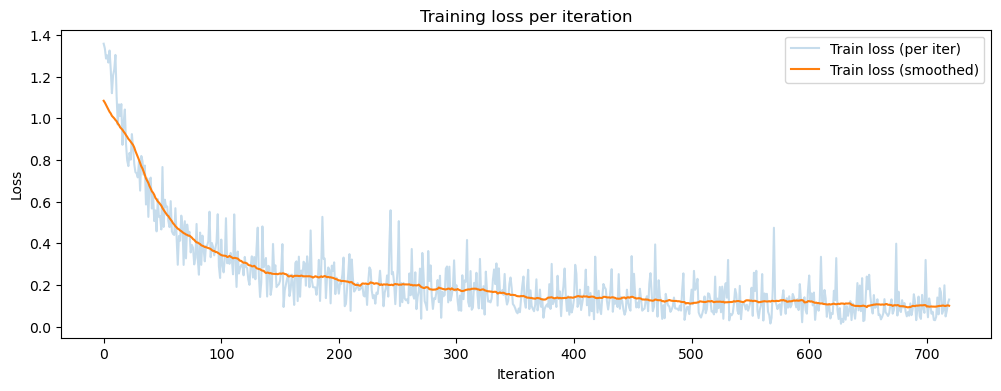

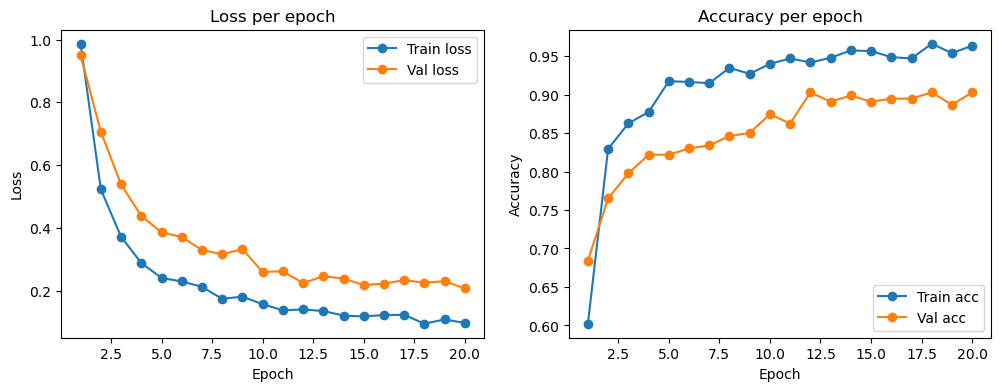

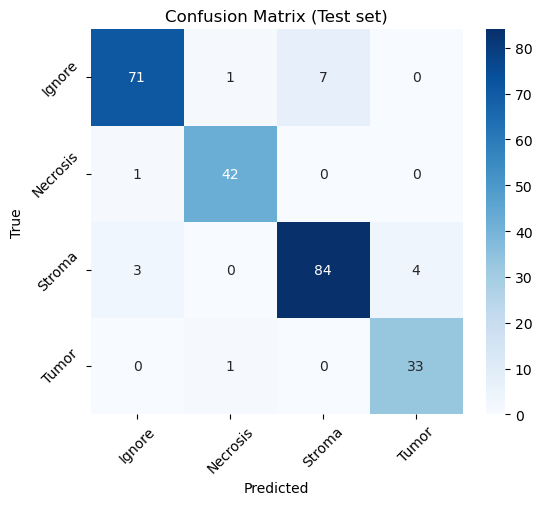

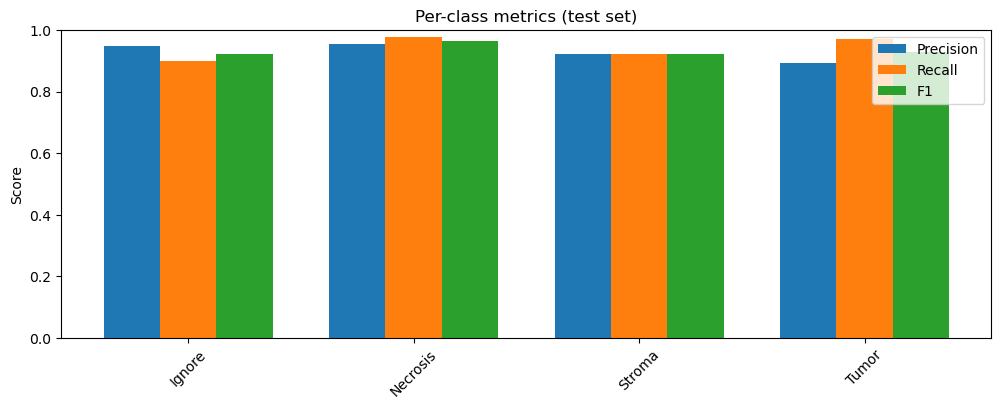

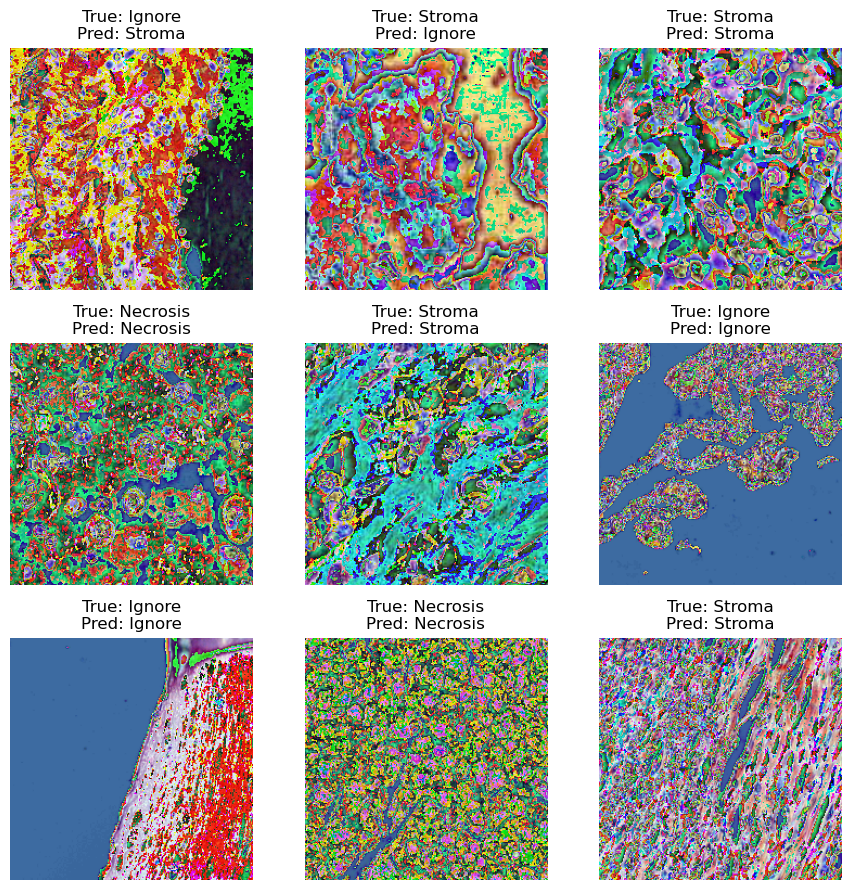

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def smooth(x, window=50):
    if len(x) < window:
        return np.array(x)
    return pd.Series(x).rolling(window, min_periods=1, center=True).mean().to_numpy()

# Per-iteration training loss (smoothed)
plt.figure(figsize=(12, 4))
plt.plot(history, alpha=0.25, label='Train loss (per iter)')
plt.plot(smooth(history, window=50), label='Train loss (smoothed)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss per iteration')
plt.legend()
plt.show()

# Epoch-level losses and accuracies
epochs = list(range(1, len(epoch_train_loss) + 1))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_train_loss, '-o', label='Train loss')
plt.plot(epochs, epoch_val_loss, '-o', label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_train_acc, '-o', label='Train acc')
plt.plot(epochs, history_val, '-o', label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.legend()
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test set)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Per-class precision, recall, f1
x = np.arange(len(labels))
width = 0.25
plt.figure(figsize=(12, 4))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1')
plt.xticks(x, labels, rotation=45)
plt.title('Per-class metrics (test set)')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.legend()
plt.show()

# Show some test images with predicted vs true labels
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()
n_show = 9
plt.figure(figsize=(9, 9))
i = 0
for (x, y) in dataloaders['test'] :
    for k in range(x.size(0)) :
        if i >= n_show :
            break
        img = x[k]
        true = labels[y[k].item()]
        pred = labels[y_pred[i]]
        plt.subplot(3, 3, i+1)
        plt.imshow(to_pil(img.cpu()))
        plt.title(f'True: {true}\nPred: {pred}')
        plt.axis('off')
        i += 1
    if i >= n_show :
        break
plt.tight_layout()
plt.show()